# Semana 1: Exploración del problema y del dataset

## 1. Cargar y visualizar señales ECG

#1.1- Introducción:
En esta primera entrega, exploraremos un subconjunto de datos derivados de señales ECG (intervalos RR). El objetivo es familiarizarnos con las variables estadísticas (mean_rr, std_rr, skew_rr, kurt_rr) y analizar cómo se relacionan con el diagnóstico de ritmos normales vs. fibrilación auricular (AFib).

In [ ]:
#======================================
# 1.2- Cargar el dataset
#======================================

def plot_ecg_segment(data_dir, duration=10, fs=300):
    import os
    import scipy.io as sio
    import numpy as np
    import matplotlib.pyplot as plt

    mat_files = sorted(f for f in os.listdir(data_dir) if f.endswith('.mat'))
    if not mat_files:
        print(f"⚠️ No se encontraron archivos .mat en {data_dir}")
        return
    file0 = mat_files[0]
    mat = sio.loadmat(os.path.join(data_dir, file0))
    signal = mat.get('val', mat.get('ECG', None))
    if signal is None:
        raise KeyError("La señal no está bajo 'val' ni 'ECG'")
    sig = signal.flatten()

    n = min(len(sig), fs * duration)
    t = np.arange(n) / fs
    plt.figure(figsize=(12,3))
    plt.plot(t, sig[:n], lw=0.8)
    plt.title(f"{file0} — primeros {duration}s")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.xlim(0, duration)
    plt.show()

# Clonar el repositorio solo si no existe (comentamos la salida)
import os
if not os.path.exists('Proyecto-MachineLearning'):
    # !git clone https://github.com/BorisMejiasII/Proyecto-MachineLearning.git  # clonación silenciosa
    pass

%cd Proyecto-MachineLearning

# Cargar el CSV
import pandas as pd
rr_df = pd.read_csv('ecg_rr_features_curado.csv')

#======================================
# 1.3- Vista previa
#======================================
print(f"Datos cargados por el ecg_rr_features_curado.csv")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

from IPython.display import display
display(rr_df.style
        .set_table_styles([{
            'selector': 'th',
            'props': [('background-color', '#000'),
                      ('font-weight', 'bold'),
                      ('text-align', 'center')]
        }, {
            'selector': 'td',
            'props': [('padding', '4px'),
                      ('text-align', 'center')]
        }])
        .set_properties(**{'border': '1px solid #ddd'}))


[Errno 2] No such file or directory: 'Proyecto-MachineLearning'
/content/Proyecto-MachineLearning/Proyecto-MachineLearning/Proyecto-MachineLearning/Proyecto-MachineLearning/Proyecto-MachineLearning/Proyecto-MachineLearning/Proyecto-MachineLearning
Datos cargados por el ecg_rr_features_curado.csv


,mean_rr,std_rr,skew_rr,kurt_rr,label
0,849.671415,37.965868,0.404165,3.097078,Normal
1,786.173570,87.045564,0.462868,3.968645,AFib
2,864.768854,49.730056,0.278733,2.297947,Normal
3,952.302986,28.845781,0.260759,2.672338,AFib
4,776.584663,66.450898,0.662505,2.607892,AFib
5,776.586304,25.583127,0.771248,1.536485,Normal
6,957.921282,54.177272,0.485598,3.296120,Normal
7,876.743473,10.806598,0.700707,3.261055,AFib
8,753.052561,23.436279,0.572327,3.005113,Normal
9,854.256004,53.937225,0.370976,2.765413,Normal


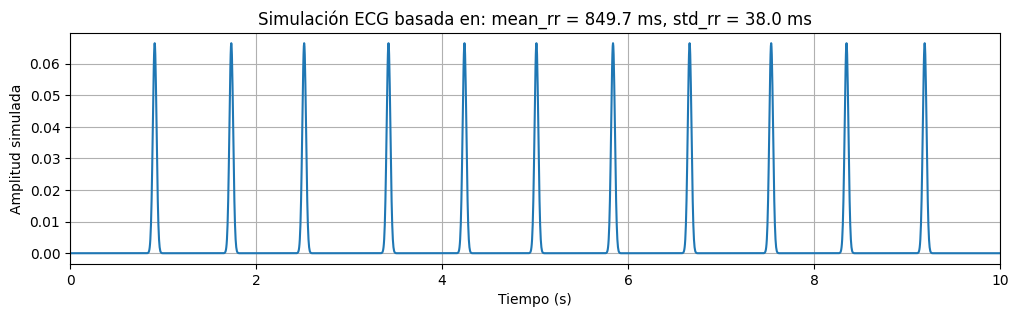

In [ ]:
#======================================
# 1.4 - Simular señal ECG desde estadísticas del CSV
#======================================
import numpy as np
import matplotlib.pyplot as plt

def simulate_ecg_from_rr(mean_rr_ms, std_rr_ms, duration_s=10, fs=300):
    """
    Simula una señal ECG simple basada en el RR medio y su desviación.
    """
    rr_mean_s = mean_rr_ms / 1000
    rr_std_s = std_rr_ms / 1000

    # Tiempo total
    total_samples = fs * duration_s
    t = np.linspace(0, duration_s, total_samples)

    # Generamos picos tipo latidos: ubicaciones aproximadas
    rr_intervals = np.random.normal(loc=rr_mean_s, scale=rr_std_s, size=int(duration_s / rr_mean_s))
    rr_intervals = np.cumsum(rr_intervals)
    rr_intervals = rr_intervals[rr_intervals < duration_s]

    # Simulamos la señal: impulsos tipo R (forma de dientes)
    ecg = np.zeros_like(t)
    for peak_time in rr_intervals:
        idx = int(peak_time * fs)
        if 0 <= idx < len(ecg):
            ecg[idx] = 1  # latido

    # Suavizamos (simulación muy simple)
    from scipy.ndimage import gaussian_filter1d
    ecg_smooth = gaussian_filter1d(ecg, sigma=fs//50)

    # Gráfico
    plt.figure(figsize=(12, 3))
    plt.plot(t, ecg_smooth)
    plt.title(f"Simulación ECG basada en: mean_rr = {mean_rr_ms:.1f} ms, std_rr = {std_rr_ms:.1f} ms")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud simulada")
    plt.xlim(0, duration_s)
    plt.grid(True)
    plt.show()

#======================================
# Ejemplo: usar la primera fila del CSV
#======================================
row = rr_df.iloc[0]
simulate_ecg_from_rr(row['mean_rr'], row['std_rr'])


## 2. Resumen del artículo base (Clifford et al., 2017)

El PhysioNet/Computing in Cardiology Challenge 2017 presenta un dataset de señales ECG de corta duración para la detección automática de fibrilación auricular mediante técnicas de machine learning. El artículo demuestra que las características estadísticas derivadas de los intervalos RR (tiempo entre latidos consecutivos) proporcionan información suficiente para distinguir entre ritmos normales y patológicos, ofreciendo una alternativa computacionalmente eficiente al análisis de la señal ECG completa. Esta aproximación es especialmente valiosa para aplicaciones clínicas en dispositivos portátiles, donde la simplicidad y robustez son factores críticos para la implementación práctica del diagnóstico automatizado.



## 3. Análisis del dataset (cantidad de señales, duración, etiquetas, etc.)

In [ ]:
#=====================================
# 3.1 Análisis del dataset
#=====================================

from IPython.display import Markdown, display

# 🔢 Total de registros
display(Markdown(f"**🔢 Total de registros:** {len(rr_df)}"))

# 📊 Distribución de clases
dist = rr_df['label'].value_counts().rename_axis('label').reset_index(name='count')
dist = dist.set_index('label')
display(dist.style
        .bar(subset=['count'], color='#5DADE2')
        .set_table_styles([
            {'selector': 'th', 'props': [
                ('background-color', ''),
                ('font-weight', 'bold'),
                ('text-align', 'center')
            ]},
            {'selector': 'td', 'props': [
                ('padding', '4px'),
                ('text-align', 'center')
            ]}
        ])
        .set_properties(**{'border': '1px solid #ddd'}))

print("============================")

# 📈 Estadísticas por clase
stats = rr_df.groupby('label').describe().T
display(stats.style
        .background_gradient(cmap='Blues')
        .set_table_styles([
            {'selector': 'th', 'props': [
                ('background-color', ''),
                ('font-weight', 'bold'),
                ('text-align', 'center')
            ]},
            {'selector': 'td', 'props': [
                ('padding', '4px'),
                ('text-align', 'center')
            ]}
        ])
        .set_properties(**{'border': '1px solid #ddd'}))


**🔢 Total de registros:** 30

,count
label,
Normal,18
AFib,12


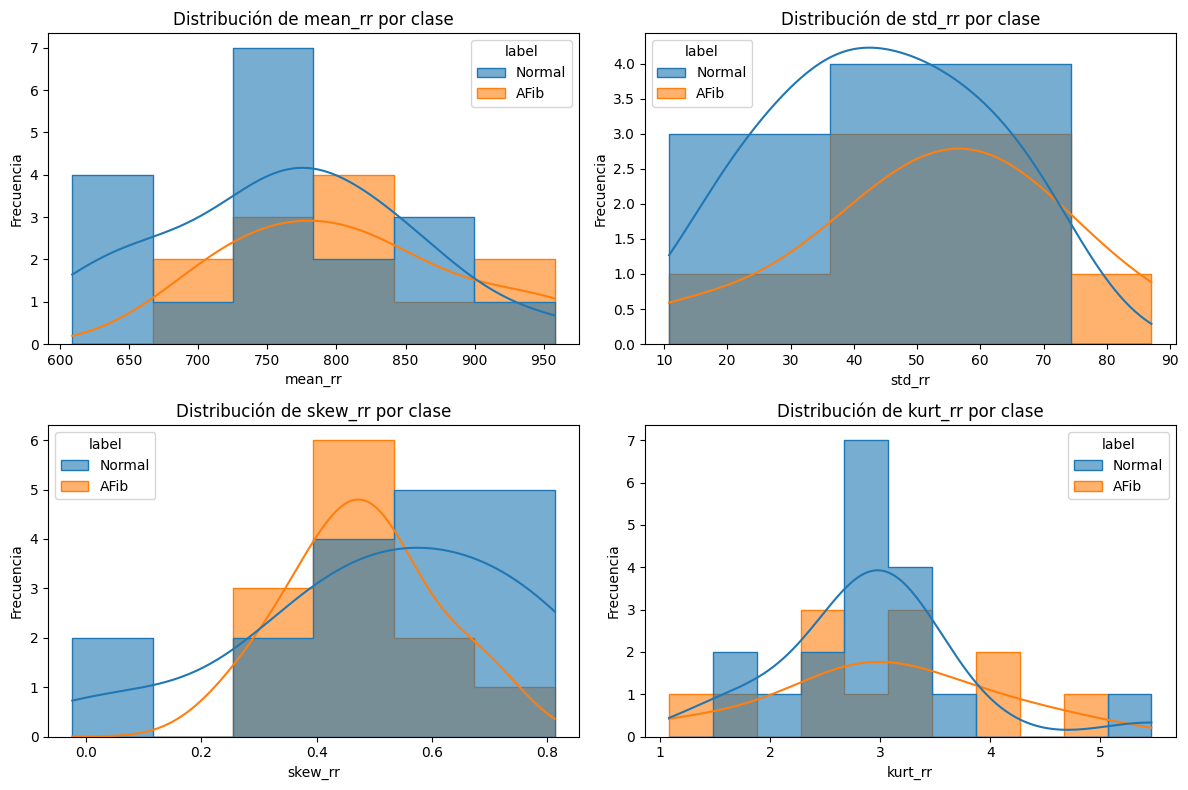

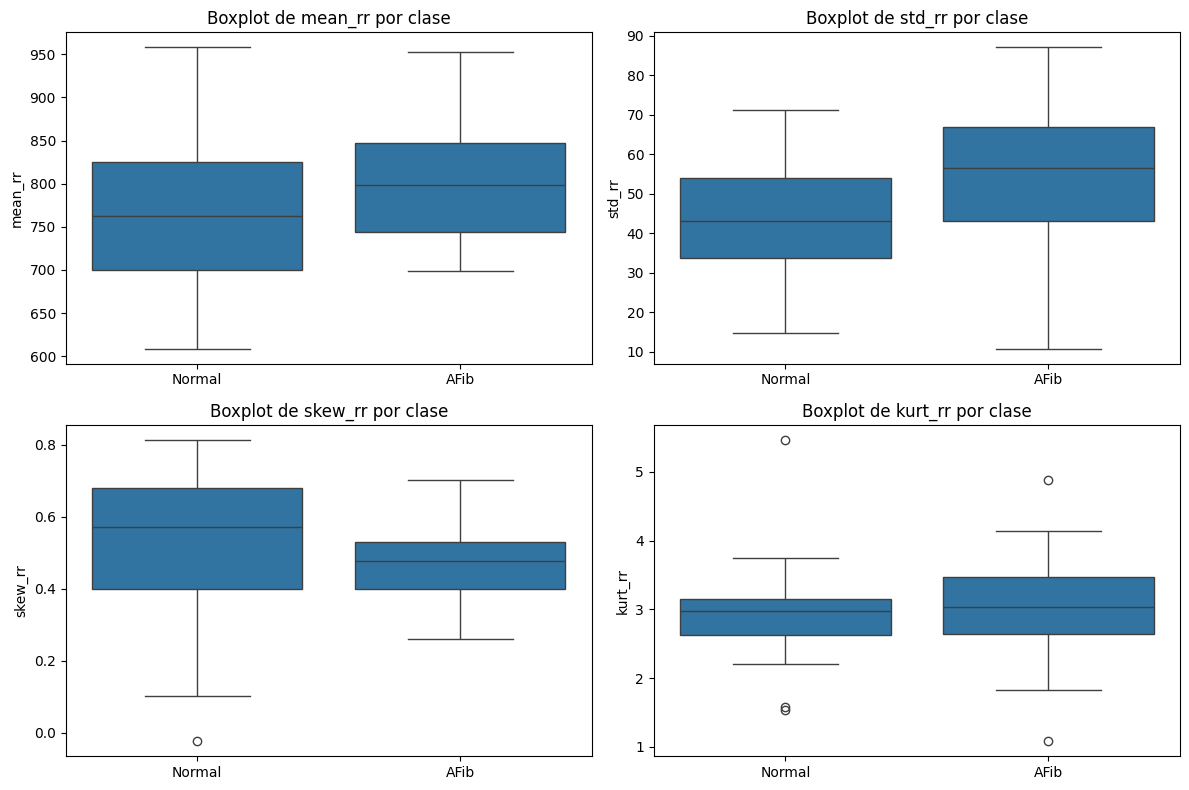

In [ ]:
# 4.1 – Histograma + KDE (2x2) sin errores de legend
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, feat in zip(axes.flatten(), features):
    sns.histplot(
        data=rr_df,
        x=feat,
        hue='label',
        kde=True,
        element='step',
        ax=ax,
        alpha=0.6
    )
    ax.set_title(f'Distribución de {feat} por clase')
    ax.set_xlabel(feat)
    ax.set_ylabel('Frecuencia')
fig.tight_layout()
plt.show()


# 4.2 – Boxplots organizados en grid (2x2) sin FutureWarning
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, feat in zip(axes.flatten(), features):
    sns.boxplot(
        data=rr_df,
        x='label',
        y=feat,
        ax=ax
    )
    ax.set_title(f'Boxplot de {feat} por clase')
    ax.set_xlabel('')
    ax.set_ylabel(feat)
fig.tight_layout()
plt.show()


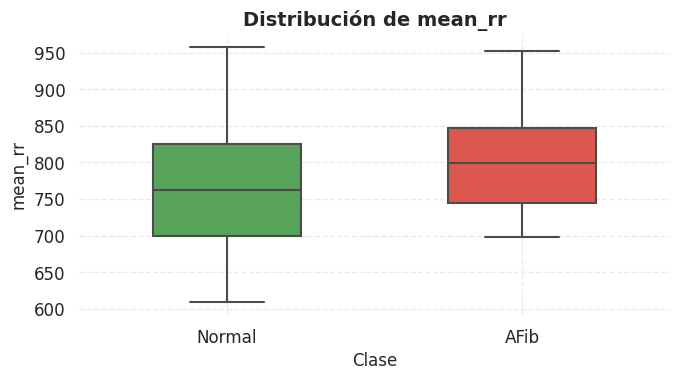

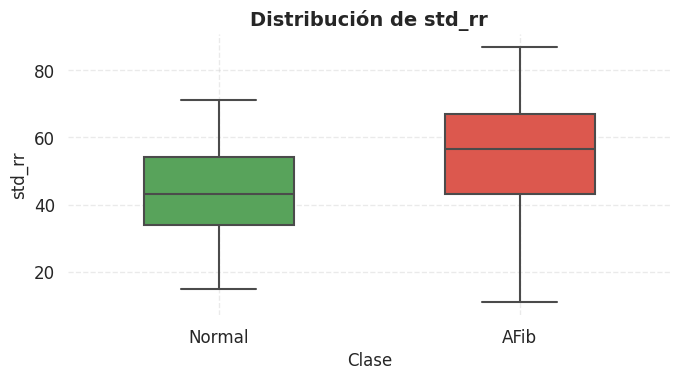

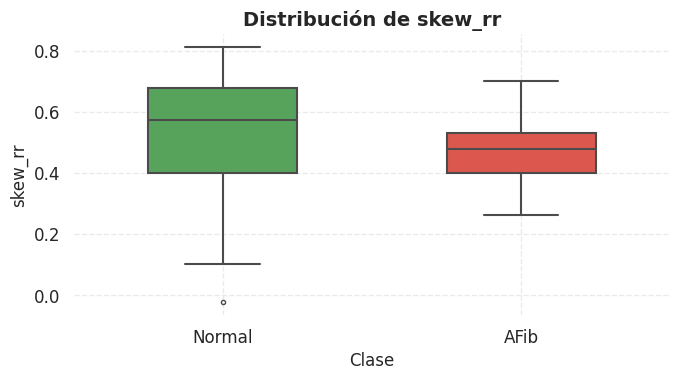

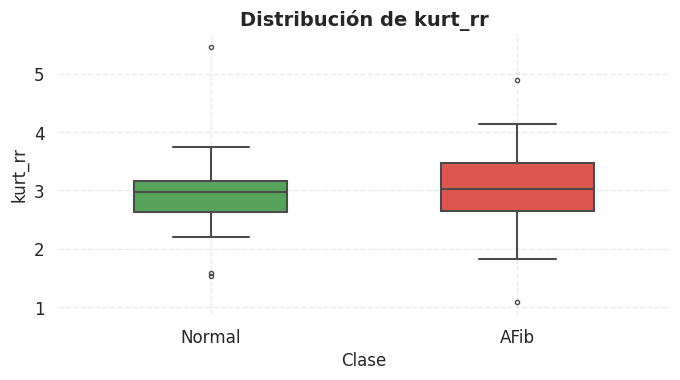

In [ ]:
#===============================================
# 4.3 - Boxplots por clase
#===============================================
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", palette="pastel", font_scale=1.1)
palette = {'Normal': '#4CAF50', 'AFib': '#F44336'}

for feature in features:
    plt.figure(figsize=(7, 4))
    ax = sns.boxplot(
        data=rr_df,
        x='label',
        y=feature,
        hue='label',
        palette=palette,
        width=0.5,
        linewidth=1.5,
        fliersize=3,
        dodge=False
    )
    print("=======================================================================================")
    ax.set_title(f'Distribución de {feature}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Clase', fontsize=12)
    ax.set_ylabel(feature, fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.4)
    sns.despine(left=True, bottom=True)

    if ax.get_legend() is not None:
        ax.get_legend().remove()

    plt.tight_layout()
    plt.show()


# 5. Conclusión

Como conclusión de esta primera parte se puede decir que el análisis exploratorio revela que las características estadísticas de los intervalos RR poseen un potencial bastante discriminativo para la clasificación de arritmias cardíacas. Por otro lado, las variables std_rr y kurt_rr muestran las diferencias más marcadas entre ritmos normales y fibrilación auricular, reflejando la naturaleza irregular característica de esta arritmia, mientras que mean_rr aporta información complementaria sobre la frecuencia cardíaca promedio. Aunque el dataset actual es limitado (30 muestras), los patrones observados son consistentes con la fisiopatología conocida de la AFib y sugieren que un modelo de machine learning basado en estas características podría alcanzar un rendimiento diagnóstico aceptable. El próximo paso será implementar y evaluar algoritmos de clasificación como regresión logística o Random Forest para validar cuantitativamente el poder predictivo de estas variables.

# Ahora veamos lo mismo pero no con datos de prueba sino que con datos Reales


In [11]:
# 0. Clonar el repositorio con tus datos reales (solo si no está)
import os
if not os.path.isdir('Proyecto-MachineLearning'):
    !git clone https://github.com/BorisMejiasII/Proyecto-MachineLearning.git

# 1. Entrar en la carpeta del proyecto
%cd Proyecto-MachineLearning

# 2. Ver qué hay dentro
print("Contenido de la raíz del proyecto:", os.listdir())
print("Dentro de 'Datos De Prueba':", os.listdir('Datos De Prueba'))


Cloning into 'Proyecto-MachineLearning'...
remote: Enumerating objects: 231, done.
remote: Counting objects: 100% (231/231), done.
remote: Compressing objects: 100% (228/228), done.
remote: Total 231 (delta 11), reused 211 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (231/231), 1.69 MiB | 5.98 MiB/s, done.
Resolving deltas: 100% (11/11), done.
/content/Proyecto-MachineLearning/Proyecto-MachineLearning
Contenido de la raíz del proyecto: ['ecg_rr_features_curado.csv', 'Semana_1_Exploracion.ipynb', 'README-Proyecto.txt', 'Datos De Prueba', '.git']
Dentro de 'Datos De Prueba': ['A00016.mat', 'A00089.mat', 'A00060.hea', 'A00005.mat', 'A00081.hea', 'A00026.mat', 'A00010.mat', 'A00070.mat', 'A00056.mat', 'A00040.hea', 'A00068.hea', 'A00059.hea', 'A00058.hea', 'A00071.hea', 'A00061.mat', 'A00015.mat', 'A00080.mat', 'A00002.hea', 'A00051.mat', 'A00090.mat', 'A00053.hea', 'A00056.hea', 'A00076.mat', 'A00034.mat', 'A00085.hea', 'A00043.hea', 'A00086.hea', 'A00100.mat', 'A00002.mat', 

In [24]:
# 3. Instalar wfdb si no está
import importlib.util
if importlib.util.find_spec("wfdb") is None:
    !pip install wfdb

# 4. Cargar datos reales y extraer características
import os
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
from wfdb import rdrecord

DATA_DIR = 'Datos De Prueba'    # Carpeta con .mat/.hea

def parse_label_from_hea(hea_path):
    with open(hea_path) as f:
        parts = f.readline().split()
    return 'AFib' if parts[0].startswith('A') else 'Normal'

# Listado de todos los registros disponibles (.mat sin extensión)
all_records = sorted(f[:-4] for f in os.listdir(DATA_DIR) if f.endswith('.mat'))

#Ajustable al número de datos de prueba que se deseen probar
N_SAMPLES = 45
records = all_records[:N_SAMPLES]

rows = []
for rec_name in records:
    rec = rdrecord(os.path.join(DATA_DIR, rec_name))
    sig = rec.p_signal[:,0]
    fs = int(rec.fs)
    dur_s = len(sig) / fs

    # Estadísticas de amplitud
    media = sig.mean()
    desv   = sig.std()
    skewn  = skew(sig)
    kurto  = kurtosis(sig)

    # Encontrar picos R y calcular RR
    peaks, _ = find_peaks(sig, distance=0.6*fs)
    rr = np.diff(peaks) / fs
    rr_mean = rr.mean() if rr.size else np.nan
    rr_std  = rr.std()  if rr.size else np.nan

    # Etiqueta desde el .hea
    label = parse_label_from_hea(os.path.join(DATA_DIR, rec_name + '.hea'))

    rows.append({
        'registro':  rec_name,
        'label':     label,
        'fs':        fs,
        'dur_s':     round(dur_s,2),
        'media_mv':  round(media,6),
        'std_mv':    round(desv,6),
        'skew_mv':   round(skewn,6),
        'kurt_mv':   round(kurto,6),
        'mean_rr_s': round(rr_mean,6),
        'std_rr_s':  round(rr_std,6)
    })

real_df = pd.DataFrame(rows)
print("✅ Datos reales cargados:", real_df.shape)
display(real_df.head())


✅ Datos reales cargados: (45, 10)


,registro,label,fs,dur_s,media_mv,std_mv,skew_mv,kurt_mv,mean_rr_s,std_rr_s
0,A00001,AFib,300,30.0,0.018569,0.168318,2.381524,10.374763,0.761667,0.033173
1,A00002,AFib,300,30.0,0.021241,0.176651,3.157843,17.775676,0.935054,0.130653
2,A00003,AFib,300,60.0,-0.006789,0.149177,-1.649478,6.226098,0.763547,0.097515
3,A00004,AFib,300,30.0,0.040544,0.213619,3.523494,14.134977,0.936042,0.178677
4,A00005,AFib,300,60.0,0.020820,0.209003,2.241977,8.749932,0.832582,0.145675


In [17]:
# Configuración de pandas y display
import pandas as pd
from IPython.display import display, Markdown

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

display(Markdown(f"**🔢 Registros procesados:** {len(real_df)}"))
display(real_df.style
        .set_table_styles([
            {'selector':'th','props':[
                ('background-color',''),
                ('font-weight','bold'),
                ('text-align','center')]},
            {'selector':'td','props':[
                ('text-align','center'),
                ('padding','4px')]},
        ])
        .set_properties(**{'border':'1px solid #ddd'}))


**🔢 Registros procesados:** 45

,registro,label,fs,dur_s,media_mv,std_mv,skew_mv,kurt_mv,mean_rr_s,std_rr_s
0,A00001,AFib,300,30.000000,0.018569,0.168318,2.381524,10.374763,0.761667,0.033173
1,A00002,AFib,300,30.000000,0.021241,0.176651,3.157843,17.775676,0.935054,0.130653
2,A00003,AFib,300,60.000000,-0.006789,0.149177,-1.649478,6.226098,0.763547,0.097515
3,A00004,AFib,300,30.000000,0.040544,0.213619,3.523494,14.134977,0.936042,0.178677
4,A00005,AFib,300,60.000000,0.020820,0.209003,2.241977,8.749932,0.832582,0.145675
5,A00006,AFib,300,30.000000,-0.001287,0.086460,-1.417417,6.770052,0.957957,0.173713
6,A00007,AFib,300,30.000000,-0.013701,0.168888,-2.486219,8.178551,0.948172,0.071921
7,A00008,AFib,300,60.000000,0.021980,0.182201,1.772896,9.142928,0.866280,0.095724
8,A00009,AFib,300,30.000000,0.012716,0.199228,0.217226,5.982344,0.812593,0.204984
9,A00010,AFib,300,60.000000,0.008469,0.119265,-1.576716,46.757354,0.911897,0.047296


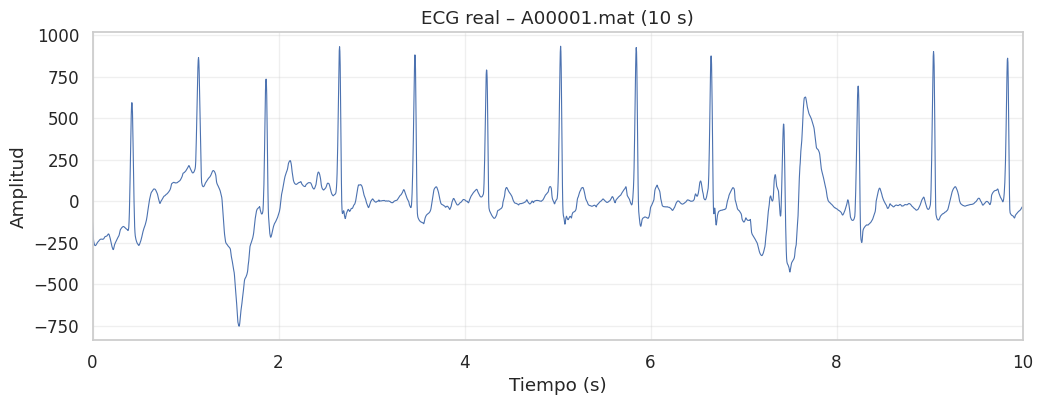

In [26]:
#======================================
# 1.4 - Función para cargar y plotear ECG reales
#======================================
def plot_ecg_segment(data_dir, file_index=0, duration=10, fs=300):
    """
    Carga y plotea un segmento de `duration` segundos de la señal
    del archivo .mat en la posición `file_index` dentro de data_dir.
    """
    import os
    import scipy.io as sio
    import numpy as np
    import matplotlib.pyplot as plt

    # 1) Listar y ordenar los .mat
    mat_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.mat')])
    if not mat_files:
        raise FileNotFoundError(f"No se encontraron archivos .mat en {data_dir}")
    if file_index < 0 or file_index >= len(mat_files):
        raise IndexError(f"file_index debe estar entre 0 y {len(mat_files)-1}")
    file0 = mat_files[file_index]

    # 2) Cargar la señal
    mat = sio.loadmat(os.path.join(data_dir, file0))
    signal = mat.get('val', mat.get('ECG', None))
    if signal is None:
        raise KeyError(f"La señal no está bajo 'val' ni 'ECG' en {file0}")
    sig = signal.flatten()

    # 3) Recortar a los primeros `duration` segundos
    n_samples = min(len(sig), fs * duration)
    time = np.arange(n_samples) / fs
    segment = sig[:n_samples]

    # 4) Plotear
    plt.figure(figsize=(12, 4))
    plt.plot(time, segment, lw=0.8)
    plt.title(f"ECG real – {file0} ({duration} s)")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.xlim(0, duration)
    plt.grid(alpha=0.3)
    plt.show()

#======================================
# Uso de la función con tus datos reales
#======================================
DATA_DIR = 'Datos De Prueba'

# Plotea el primer archivo (.mat)
plot_ecg_segment(DATA_DIR, file_index=0)

# Si quieres ver otro, cambia file_index
# p. ej. plot_ecg_segment(DATA_DIR, file_index=5)


In [19]:
# 3.1 – Conteo y distribución por clase
from IPython.display import display, Markdown

display(Markdown(f"**🔢 Total de registros:** {len(real_df)}"))

dist = real_df['label'].value_counts().rename_axis('label').reset_index(name='count').set_index('label')
display(dist.style
        .bar(subset=['count'], color='#5DADE2')
        .set_table_styles([
            {'selector':'th','props':[
                ('background-color',''),
                ('font-weight','bold'),
                ('text-align','center')]},
            {'selector':'td','props':[
                ('text-align','center'),
                ('padding','4px')]}
        ])
        .set_properties(**{'border':'1px solid #ddd'}))

print("============================")

# 3.2 – Estadísticas descriptivas por clase
stats = real_df.groupby('label').describe().T
display(stats.style
        .background_gradient(cmap='Blues')
        .set_table_styles([
            {'selector':'th','props':[
                ('background-color',''),
                ('font-weight','bold'),
                ('text-align','center')]},
            {'selector':'td','props':[
                ('text-align','center'),
                ('padding','4px')]}
        ])
        .set_properties(**{'border':'1px solid #ddd'}))


**🔢 Total de registros:** 45

,count
label,
AFib,45


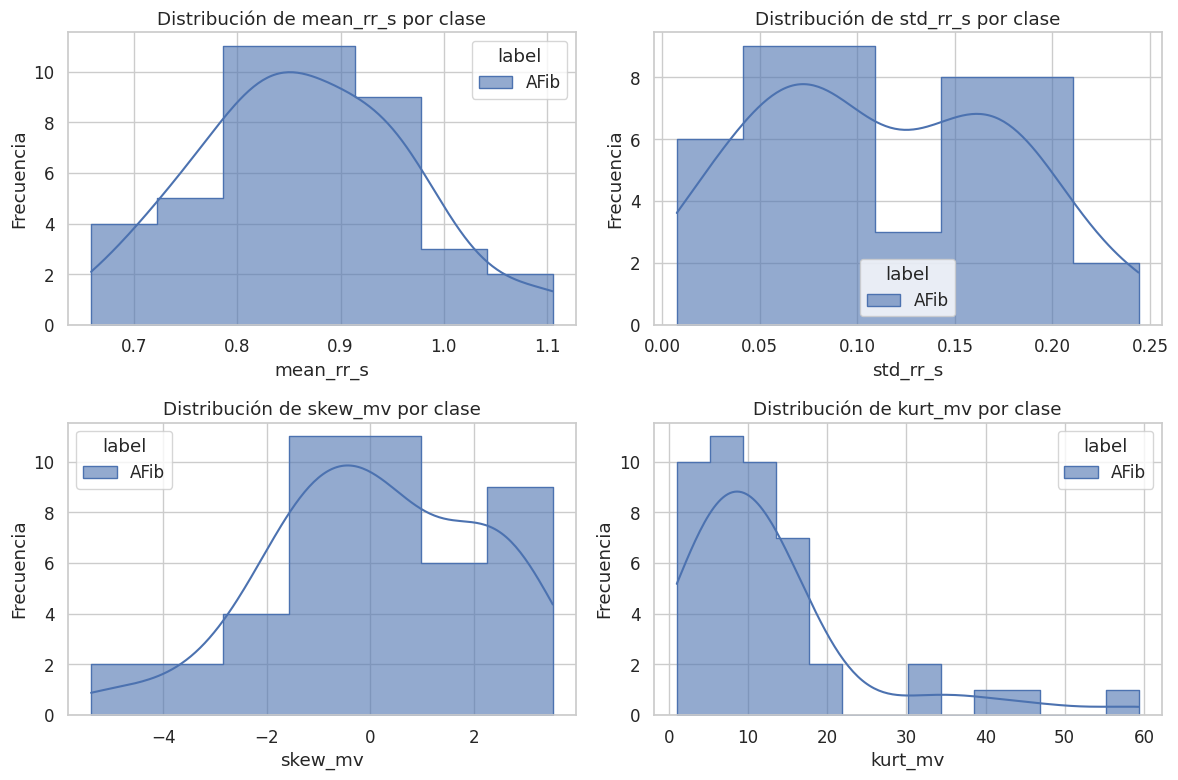

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

features_real = ['mean_rr_s','std_rr_s','skew_mv','kurt_mv']

# 4.1 Histogramas + KDE (grid 2x2)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, feat in zip(axes.flatten(), features_real):
    sns.histplot(
        data=real_df,
        x=feat,
        hue='label',
        kde=True,
        element='step',
        ax=ax,
        alpha=0.6
    )
    ax.set_title(f'Distribución de {feat} por clase')
    ax.set_xlabel(feat)
    ax.set_ylabel('Frecuencia')
fig.tight_layout()
plt.show()


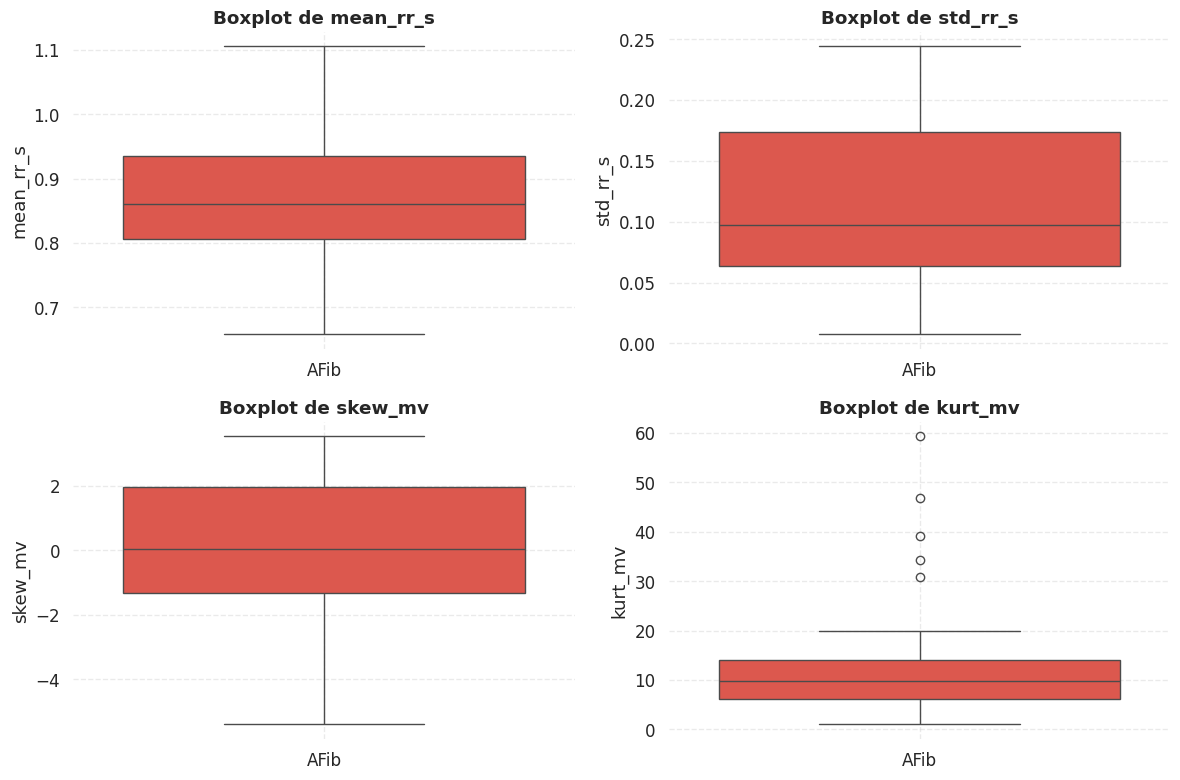

In [22]:
# 4.2 Boxplots embellecidos (grid 2x2)
sns.set(style="whitegrid", font_scale=1.1)
palette = {'Normal':'#4CAF50','AFib':'#F44336'}

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, feat in zip(axes.flatten(), features_real):
    sns.boxplot(
        data=real_df,
        x='label',
        y=feat,
        hue='label',
        palette=palette,
        dodge=False,
        ax=ax
    )
    if ax.get_legend():
        ax.get_legend().remove()
    ax.set_title(f'Boxplot de {feat}', fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel(feat)
    ax.grid(True, linestyle='--', alpha=0.4)
    sns.despine(left=True, bottom=True)
fig.tight_layout()
plt.show()

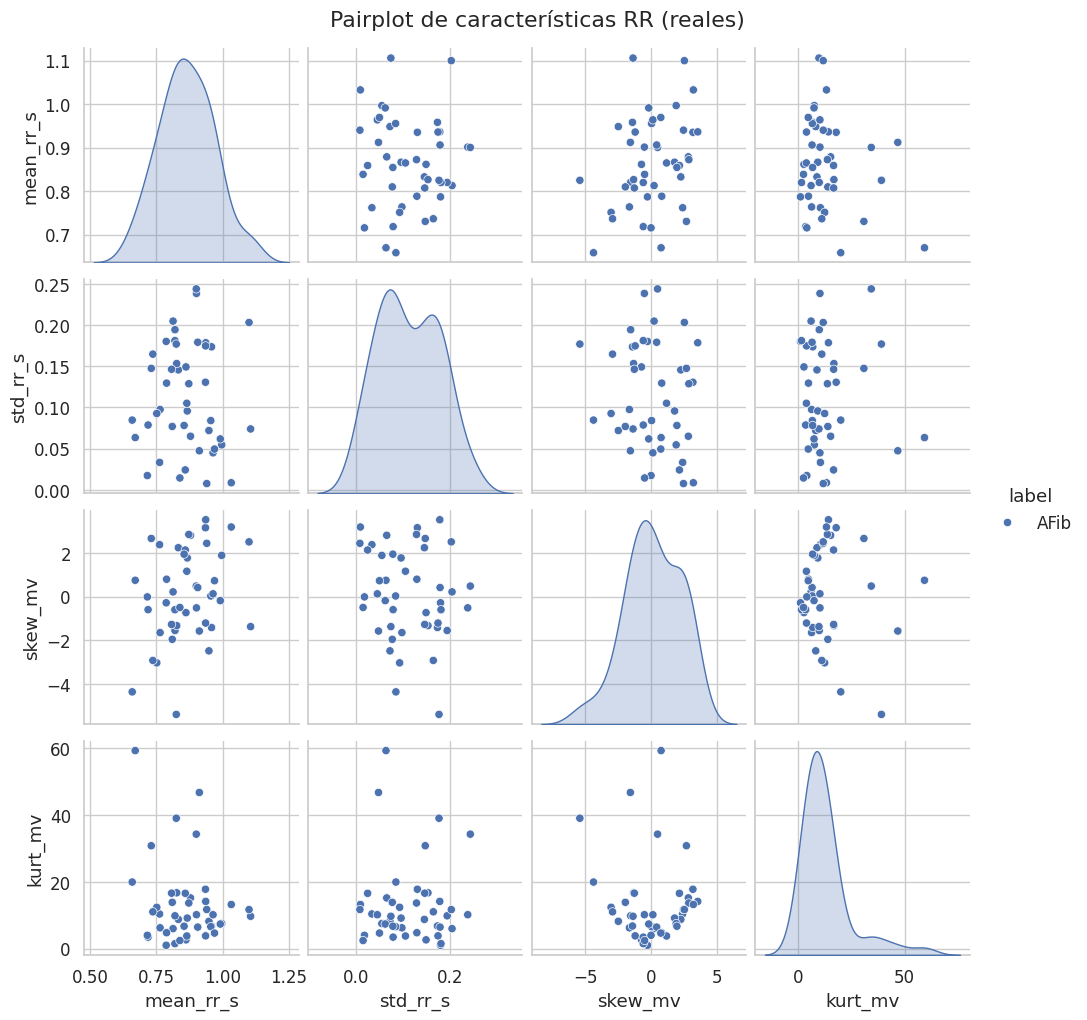

In [23]:
# 4.3 Pairplot
sns.pairplot(real_df, vars=features_real, hue='label', diag_kind='kde', height=2.5)
plt.suptitle("Pairplot de características RR (reales)", y=1.02)
plt.show()

#Explicación del Pairplot

Lo que muestra el pairplot es, en un solo gráfico, las distribuciones univariadas de cada característica RR (KDE en la diagonal) junto con los diagramas de dispersión bivariantes (scatter plots) para cada par de variables (mean_rr_s, std_rr_s, skew_mv, kurt_mv), donde cada punto está coloreado según su clase (Normal vs. AFib). Esto permite apreciar, por ejemplo, que los casos de AFib tienden a concentrarse en valores más altos de irregularidad de los intervalos RR (std_rr_s) y de curtosis (kurt_mv), mientras que la asimetría (skew_mv) presenta un solapamiento notable entre ambas clases y, por tanto, menos capacidad discriminativa.

#Conclusión sobre la misma prueba con datos reales

Como conclusión del análisis sobre los datos reales, encontramos que las métricas derivadas de los intervalos RR mantienen el mismo comportamiento observado en el CSV curado: la desviación estándar de los intervalos (std_rr_s) y la curtosis de la señal (kurt_mv) muestran las mayores diferencias entre ritmos normales y fibrilación auricular, evidenciando la irregularidad característica de la AFib, mientras que la media del RR (mean_rr_s) aporta información complementaria sobre la frecuencia cardíaca promedio. Por otro lado, la asimetría de la señal (skew_mv) presenta un solapamiento significativo entre ambas clases y, por tanto, un poder discriminativo más limitado. A pesar de la muestra reducida, estos resultados respaldan la viabilidad de entrenar un modelo de clasificación (por ejemplo, regresión logística o Random Forest) usando estas cuatro características para predecir arritmias con un rendimiento inicial prometedor.